# Linear fit of Bouguer lines on  AuxTel Data


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June 17th 2022
- update : June 18th 2022



** Kernel anaconda3_auxtel**




# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits',
 'comptable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits',
 'thermtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate

# Functions

In [6]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [7]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [8]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [9]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [10]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)  
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [11]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    Input arguments :
    
    - Npoints : number of wavelength samples,
    - wl: array of wavelength
    - time : array of time
    - magref : reference of magnitudes
    
    Return:
    
    """
    
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
   
    
    # create the array of wavelength
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    # create label
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # index of nearest wavelegth
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    # number of wavelength bins
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    # the abscisse
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop on the bin range    
    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        # creat the array
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right',bbox_to_anchor=(1.05,1))
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("transmission (mag)")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [12]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="transmission vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    """
    
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

        
    # loop on wavelength    
    fit_results = []
    fit_flag = []
    
    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey) # remove bad errors
        
        
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
       
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
       
            if popt[0] > 0 :
                # plot points
                ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
                # plot fitted lines
                ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
            
            else:
                msg = f"Remove wavelength {iwl}, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
            
                
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
                       
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("transmission (mag)")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

In [13]:
def GetBouguerLinesAtmRelativetoZero(Npoints,wl,airmass,magref ,emag,title="transmission vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    """
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop on wavelength
    
    fit_results = [] # contains the result of the fit popt
    fit_flag = []    # quality flag
    
    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        

     
            
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        intercept =  popt[-1]
        
        
        
        if FLAG_PLOT:
            
            if popt[0] > 0 : 
                ax.plot(the_x,the_y - intercept,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y - intercept,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
            
                ax.plot(x_fit,y_fit - intercept,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up- intercept, y_fit_dw - intercept, alpha=.25, color="gray")
                
            
            else:
                msg = f"Remove wavelength {iwl}, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
               
       
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
            
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("transmission (mag)")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

# Constants

# Initialisation

In [14]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [15]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-06-18 16:27:59,021 jns-dagoret.cc.in2p3.fr __main__[3715] INFO LA time:07:27:59
2022-06-18 16:27:59,024 jns-dagoret.cc.in2p3.fr __main__[3715] INFO NY time:10:27:59
2022-06-18 16:27:59,026 jns-dagoret.cc.in2p3.fr __main__[3715] INFO London time:15:27:59
2022-06-18 16:27:59,028 jns-dagoret.cc.in2p3.fr __main__[3715] INFO Paris time:16:27:59
2022-06-18 16:27:59,028 jns-dagoret.cc.in2p3.fr __main__[3715] INFO ************************ START *********************


In [16]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [17]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220317-configFFM.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-06-18 16:27:59,049 jns-dagoret.cc.in2p3.fr __main__[3715] INFO Configuration file : config/confprog_run-auxtel-holo-20220317-configFFM.ini


In [18]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-06-18 16:27:59,063 jns-dagoret.cc.in2p3.fr __main__[3715] INFO 1) Configuration


In [19]:
config_section = config.sections()

In [20]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [21]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [22]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-06-18 16:27:59,122 jns-dagoret.cc.in2p3.fr __main__[3715] INFO  Object observed MU col at AUXTEL/Rubin Obs (2022-03-17)


In [23]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [24]:
inputfile

'run-auxtel-holo-20220317-config_DECONVOLUTION_FFM.pickle'

In [25]:
list_of_badnums = [int(nn)  for nn in BADEXPOS.split()]

list_of_badnums

[251, 300, 301, 428, 429]

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [26]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [27]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [28]:
targetname = s0.fheader['TARGETID']

In [29]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

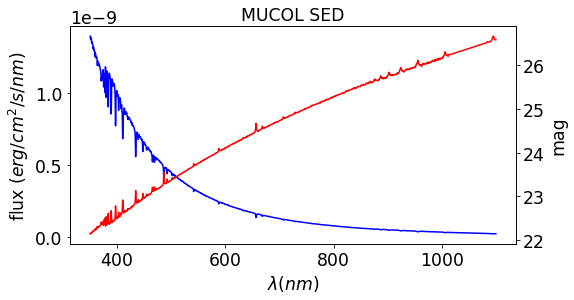

In [30]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

## spectrum data

In [31]:
fullfilename=os.path.join(inputdir,inputfile)

In [32]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [33]:
NBSPECTRA=len(summary_content)

In [34]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-06-18 16:28:00,296 jns-dagoret.cc.in2p3.fr __main__[3715] INFO  Number of selected files is 56


In [35]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [36]:
infos, all_spectra = GetSpectra(summary_content)

In [37]:
infos.head()

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,237,mu. Col,2022-03-18T00:50:48.964,0.000000,1.114453,743.45,8.9,48.0,exposure_2022031700237_postisrccd_spectrum.fits,315.585349,1736.068854,0.192804,180.734482
1,238,mu. Col,2022-03-18T00:51:22.049,0.009190,1.115575,743.45,8.9,48.0,exposure_2022031700238_postisrccd_spectrum.fits,320.561914,1737.931079,0.208636,186.166289
2,244,mu. Col,2022-03-18T00:54:16.312,0.057597,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits,308.020361,1732.278663,0.193445,181.171270
3,245,mu. Col,2022-03-18T00:54:49.235,0.066742,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits,305.787486,1732.483307,0.191892,180.998286
4,251,mu. Col,2022-03-18T00:57:47.565,0.116278,1.129107,743.40,8.9,50.0,exposure_2022031700251_postisrccd_spectrum.fits,307.486978,1741.027850,0.209163,189.211926


In [38]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,299.843907,1.294906e-12,1.199674e-14,299.137719,5462.404174,51.594588
1,300.197460,1.196438e-12,1.002146e-14,299.491278,5026.676774,42.898032
2,300.551011,1.052286e-12,7.987621e-15,299.844835,4402.310405,34.047471
3,300.904560,8.634455e-13,6.917208e-15,300.198388,3593.833616,29.438372
4,301.258105,6.621412e-13,6.917912e-15,300.551939,2739.086715,29.427650


# Remove bad Spectra

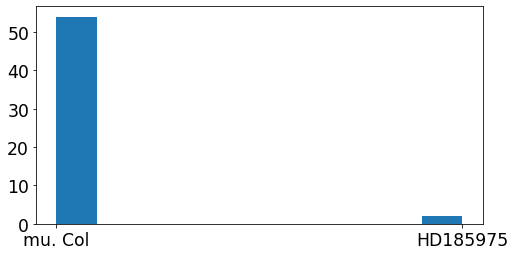

In [39]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);

Text(0.5, 0.98, 'Variables to apply selection')

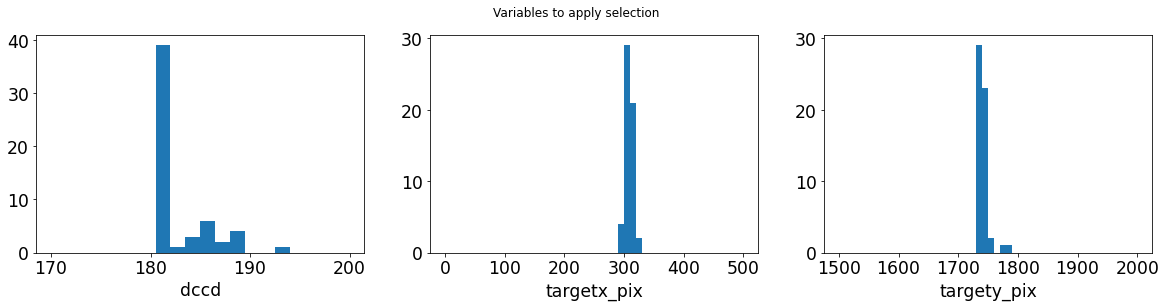

In [40]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define sepection cut

In [41]:
selection_cut = ((infos.d2ccd > 180) & (infos.d2ccd < 182)) & (infos.object == "mu. Col")
bad_cut = ~selection_cut

In [42]:
list_of_badnums = infos[bad_cut]["number"].values
list_of_badnums

array([238, 251, 259, 266, 293, 294, 317, 337, 338, 344, 359, 366, 414,
       415, 428, 429, 436, 442, 443])

## First Does not remove bad

In [43]:
NBSPECTRA = len(all_spectra)

In [44]:
assert NBSPECTRA == len(infos)

In [45]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [46]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-06-18 16:28:01,442 jns-dagoret.cc.in2p3.fr __main__[3715] INFO  Number of good spectra is 56


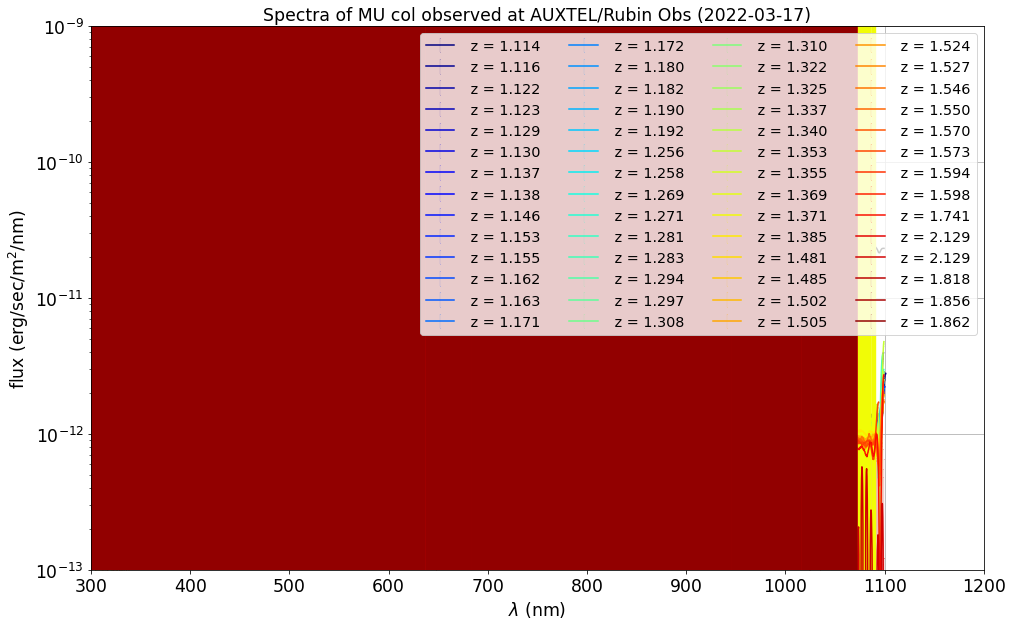

In [47]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

# Convert Not filtered spectra into Mag table

In [48]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(infos,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


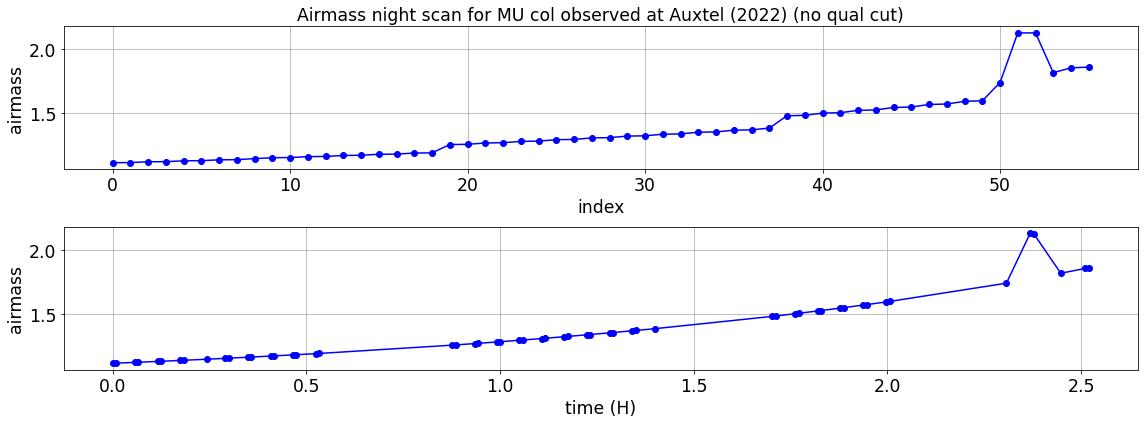

In [49]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel (2022) (no qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()

plt.tight_layout()


In [50]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [51]:
MagsRef1=Mags1-sed_mag0
title="instrumental magnitude - sed magnitude vs time"

In [52]:
EMags1

array([[ 7.76991746e-03,  6.85087239e-03,  6.09380528e-03, ...,
         1.15256699e-02,  1.15358518e-02,  1.15498869e-02],
       [ 1.25912816e-02,  1.21665077e+04, -9.09762323e-02, ...,
         8.92889679e-01, -8.52708239e-01, -3.91947709e-01],
       [ 1.54979118e-02,  1.37392024e-02,  1.22845607e-02, ...,
         3.20496210e-02,  3.16661290e-02,  3.14807974e-02],
       ...,
       [ 1.06212016e-03, -1.29217732e-03,  1.02793771e-03, ...,
        -6.93846932e-02, -3.94308988e-02,  1.24783677e-01],
       [-5.14567307e-06,  5.01915735e-04, -4.78055876e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.31369779e-04,  2.87259001e-04, -1.47393167e-02, ...,
        -1.34089533e-01,  1.88807181e-01,  9.28069605e-03]])

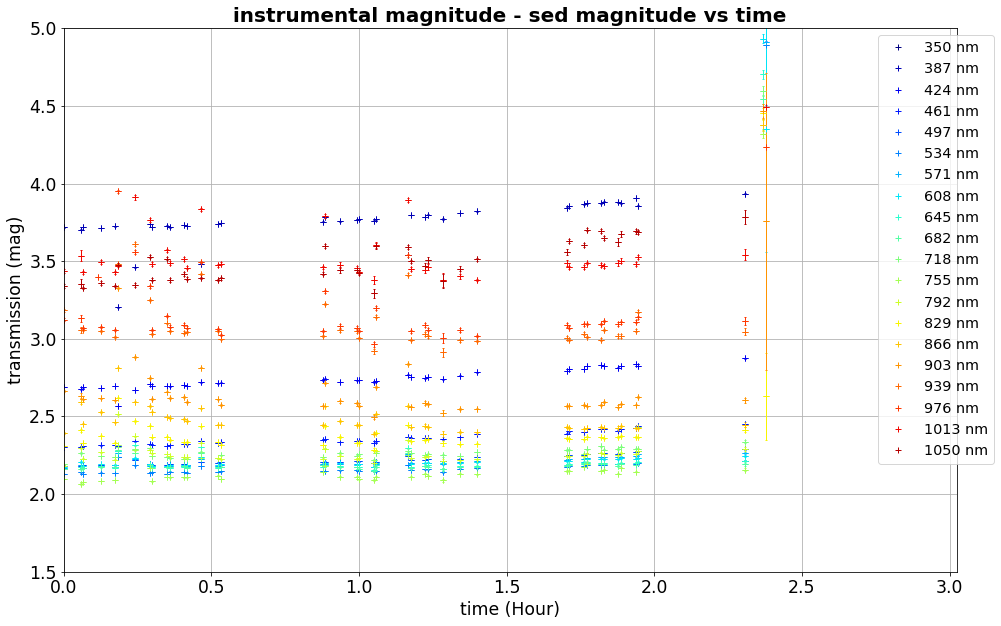

In [53]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef1,EMags1,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

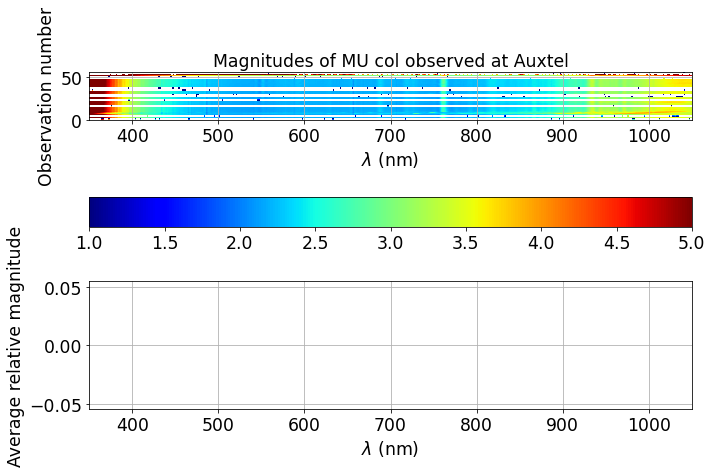

In [54]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBSPECTRA)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef1,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Auxtel"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef1,axis=0)
ax2.plot(WL,Y,"b-")
#ax2.set_ylim(2,4)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Filtered spectra

In [55]:
list_of_badnums

array([238, 251, 259, 266, 293, 294, 317, 337, 338, 344, 359, 366, 414,
       415, 428, 429, 436, 442, 443])

In [56]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 1 for exposure 238
Remove spectrum 4 for exposure 251
Remove spectrum 7 for exposure 259
Remove spectrum 8 for exposure 266
Remove spectrum 15 for exposure 293
Remove spectrum 16 for exposure 294
Remove spectrum 22 for exposure 317
Remove spectrum 27 for exposure 337
Remove spectrum 28 for exposure 338
Remove spectrum 29 for exposure 344
Remove spectrum 34 for exposure 359
Remove spectrum 36 for exposure 366
Remove spectrum 48 for exposure 414
Remove spectrum 49 for exposure 415
Remove spectrum 51 for exposure 428
Remove spectrum 52 for exposure 429
Remove spectrum 53 for exposure 436
Remove spectrum 54 for exposure 442
Remove spectrum 55 for exposure 443


In [57]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,237,mu. Col,2022-03-18T00:50:48.964,0.000000,1.114453,743.45,8.9,48.0,exposure_2022031700237_postisrccd_spectrum.fits,315.585349,1736.068854,0.192804,180.734482
2,244,mu. Col,2022-03-18T00:54:16.312,0.057597,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits,308.020361,1732.278663,0.193445,181.171270
3,245,mu. Col,2022-03-18T00:54:49.235,0.066742,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits,305.787486,1732.483307,0.191892,180.998286
5,252,mu. Col,2022-03-18T00:58:20.709,0.125485,1.130309,743.40,8.9,50.0,exposure_2022031700252_postisrccd_spectrum.fits,308.237192,1740.105221,0.189290,181.103716
6,258,mu. Col,2022-03-18T01:01:18.728,0.174934,1.136923,743.40,8.9,53.0,exposure_2022031700258_postisrccd_spectrum.fits,316.116144,1737.034501,0.192679,181.010609
9,272,mu. Col,2022-03-18T01:08:18.080,0.291421,1.153339,743.30,8.9,51.0,exposure_2022031700272_postisrccd_spectrum.fits,313.829696,1738.004465,0.197031,180.821888
10,273,mu. Col,2022-03-18T01:08:50.992,0.300563,1.154683,743.35,8.9,51.0,exposure_2022031700273_postisrccd_spectrum.fits,311.561151,1739.437465,0.189327,181.120576
11,279,mu. Col,2022-03-18T01:11:46.031,0.349185,1.161939,743.40,8.9,53.0,exposure_2022031700279_postisrccd_spectrum.fits,308.000273,1739.511651,0.190627,181.068891
12,280,mu. Col,2022-03-18T01:12:18.936,0.358326,1.163327,743.40,8.9,53.0,exposure_2022031700280_postisrccd_spectrum.fits,306.876884,1741.352349,0.186678,181.094828
13,286,mu. Col,2022-03-18T01:15:18.583,0.408228,1.171053,743.45,8.9,54.0,exposure_2022031700286_postisrccd_spectrum.fits,303.959275,1742.577882,0.182337,180.988135


# Convert Not filtered spectra into Mag table

In [58]:
NBSPECTRA=len(all_spectra)

In [59]:
assert NBSPECTRA == len(infos)

In [60]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [61]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-06-18 16:28:22,235 jns-dagoret.cc.in2p3.fr __main__[3715] INFO  Number of good spectra is 37


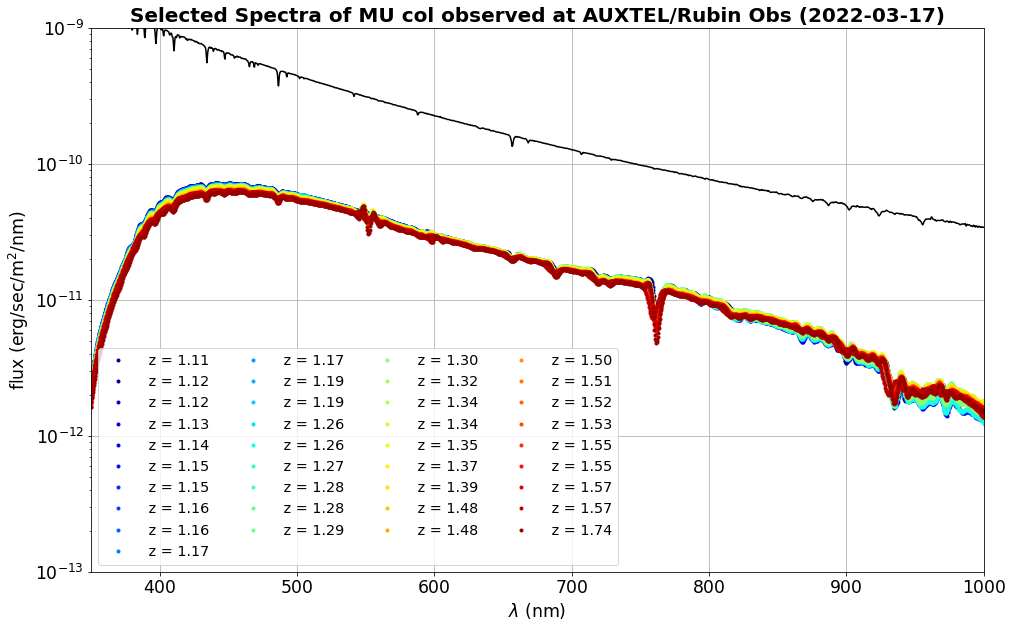

In [62]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(350,1000)
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)

In [63]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

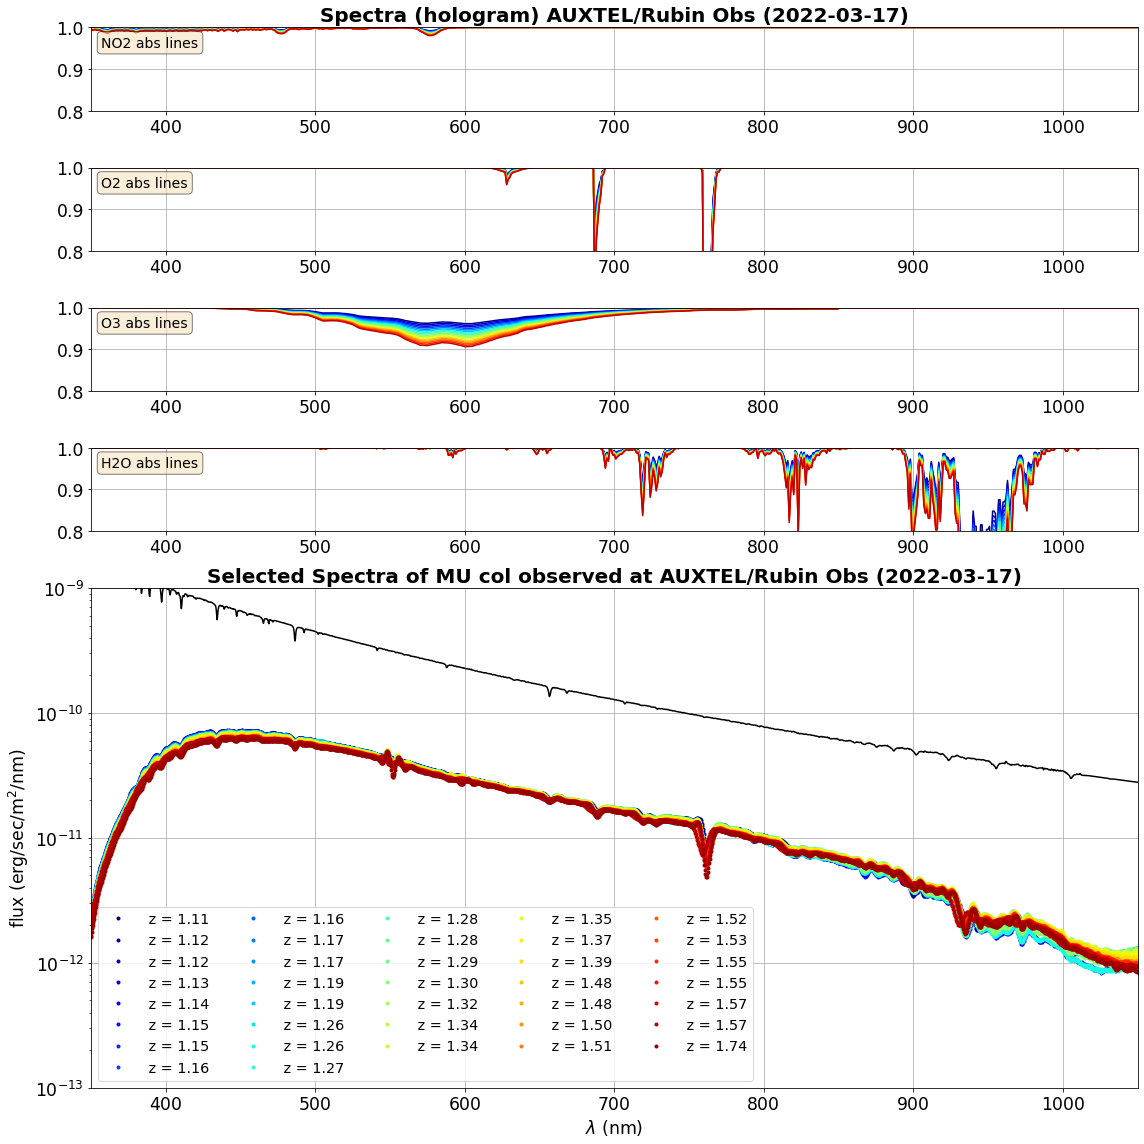

In [64]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)

plt.tight_layout()


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


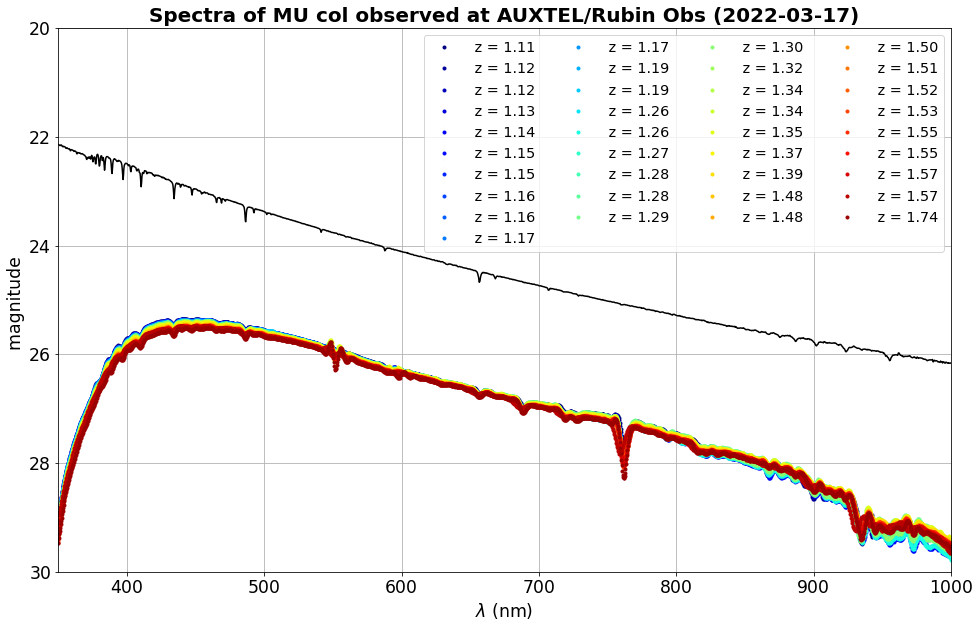

In [65]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(350,1000)
ax.set_ylim(20,30)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)

## Convert to image

In [66]:
WL,Mags2,EMags2 ,AirM,Tim = ConvertToImage(infos,all_spectra, WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

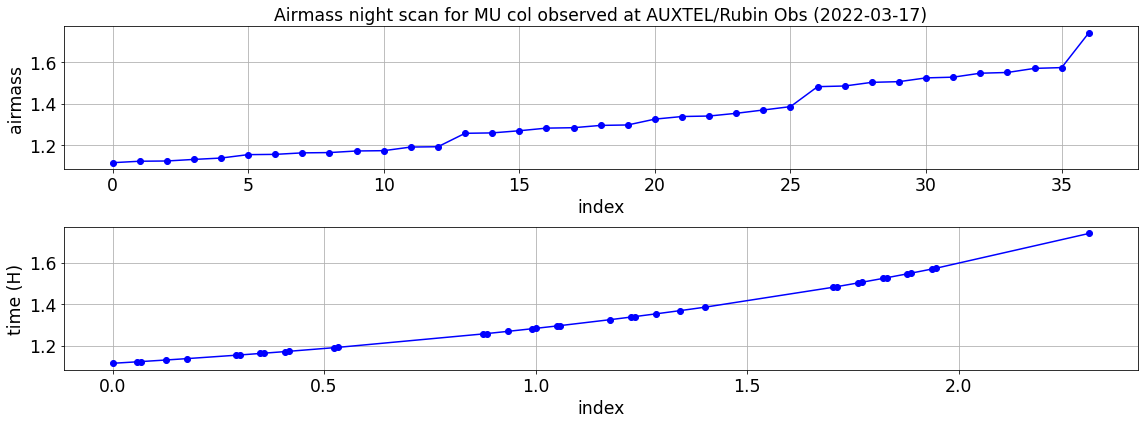

In [67]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at {SITE} ({DATE})"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

In [68]:
MagsRef2=Mags2-sed_mag0
title=f"instrumental magnitude - sed magnitude vs time, object {target} at {SITE} ({DATE})"

In [69]:
MagsRef2.shape

(37, 701)

In [70]:
EMags2.shape

(37, 701)

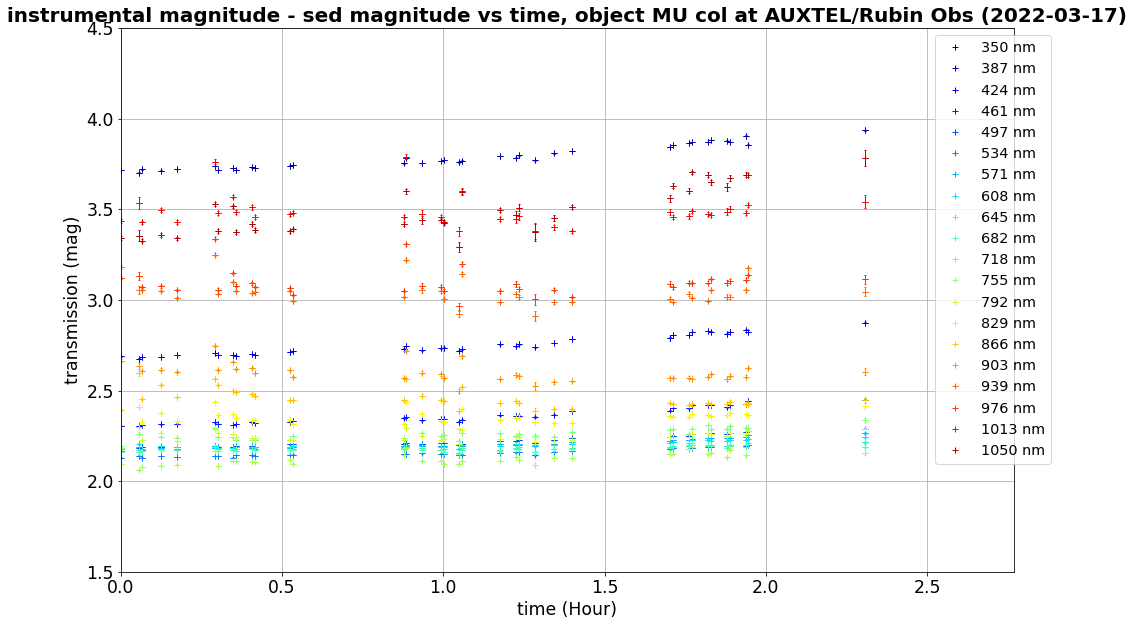

In [71]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef2,EMags2,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=4.5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

# Quality selection of observations

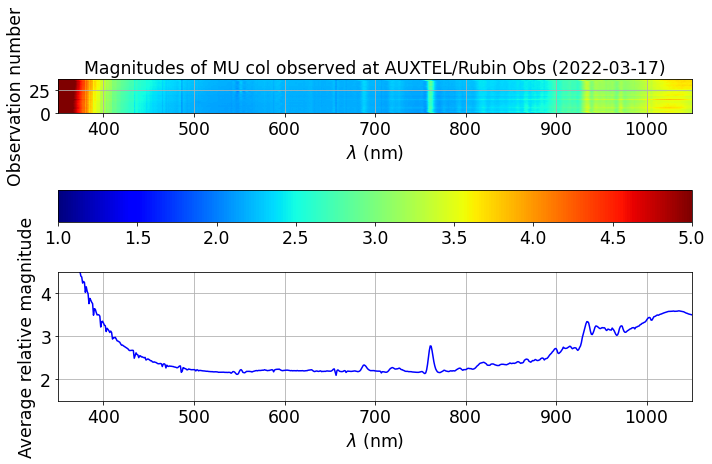

In [72]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBSPECTRA)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef2,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at {SITE} ({DATE})"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef2,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(1.5,4.5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Bouguer line

In [73]:
title=f"instrumental magnitude - sed magnitude vs time, object {target} at {SITE} ({DATE})"

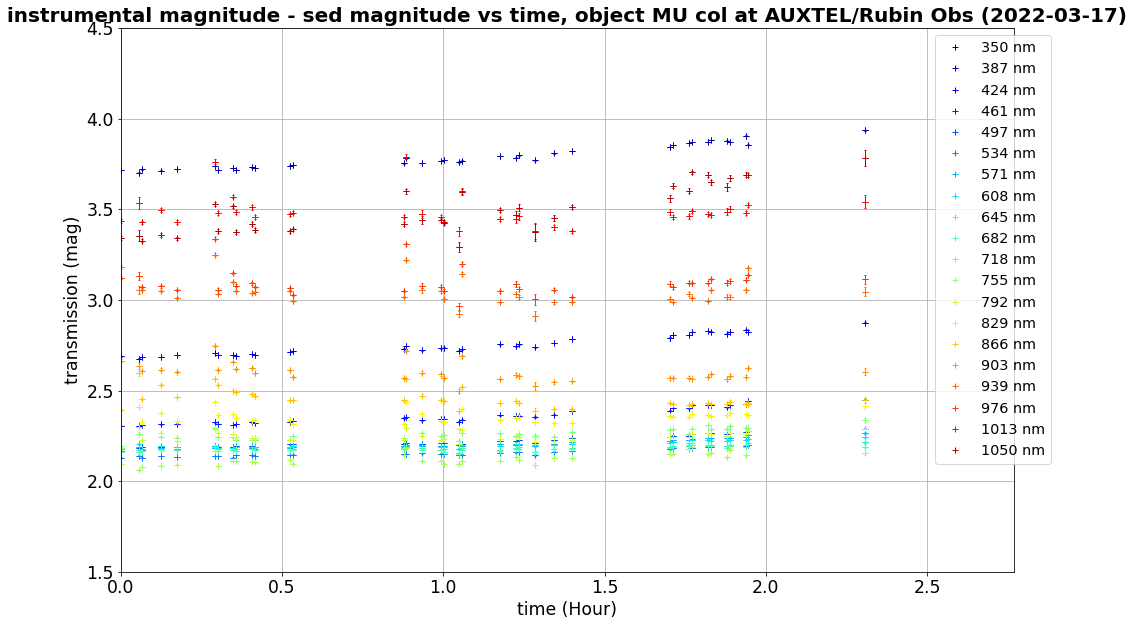

In [74]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef2,EMags2,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=4.5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [75]:
title=f"instrumental magnitude - sed magnitude vs airmass, object {target} at {SITE} ({DATE})"

Remove wavelength 516, bad fit slope = -0.15256925541359956, intercept = 2.658075331612705
Remove wavelength 553, bad fit slope = -0.11649116294978605, intercept = 2.753052265495466
Remove wavelength 589, bad fit slope = -0.0878140818979776, intercept = 3.161034722993991
Remove wavelength 626, bad fit slope = -0.011653677107565435, intercept = 3.108817065914066
Remove wavelength 663, bad fit slope = -0.04312507874584961, intercept = 3.5448624484713456


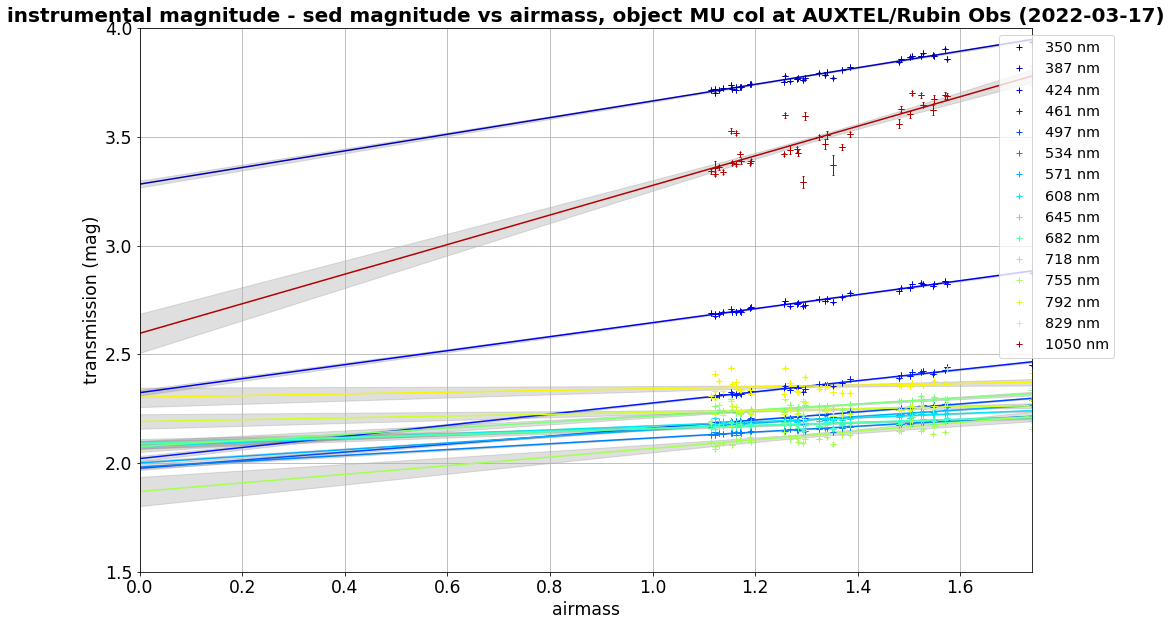

In [76]:
w,m,e,flag,res=GetBouguerLinesAtm(NPOINTSVIEW,WL,AirM,MagsRef2,EMags2,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=4,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

Remove wavelength 516, bad fit slope = -0.15256925541359956, intercept = 2.658075331612705
Remove wavelength 553, bad fit slope = -0.11649116294978605, intercept = 2.753052265495466
Remove wavelength 589, bad fit slope = -0.0878140818979776, intercept = 3.161034722993991
Remove wavelength 626, bad fit slope = -0.011653677107565435, intercept = 3.108817065914066
Remove wavelength 663, bad fit slope = -0.04312507874584961, intercept = 3.5448624484713456


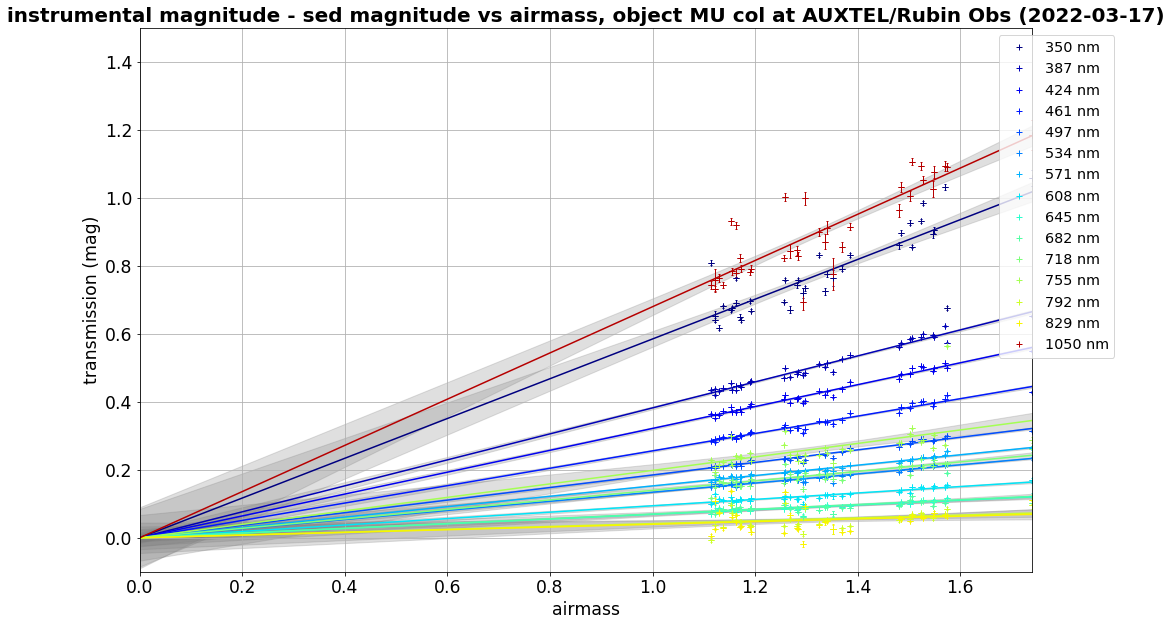

In [77]:
w,m,e,flag,res=GetBouguerLinesAtmRelativetoZero(NPOINTSVIEW,WL,AirM,MagsRef2,EMags2,title=title,FLAG_PLOT=True,YMIN=-0.1,YMAX=1.5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

# Throughput

In [78]:
w_s1,m_s1,em_s1,flag,res=GetBouguerLinesAtm(NPOINTSSAVE,WL,AirM,MagsRef2,EMags2,FLAG_PLOT=False,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [79]:
transm_s1=np.power(10,-m_s1/2.5)
etransm_s1=em_s1*transm_s1

In [80]:
transm_s1.shape

(300,)

In [81]:
transm_s1[flag].shape

(227,)

In [82]:
factor=1.0 # suppose Spectractor has divided the flux by Ronchi efficiency
transm_s1=transm_s1*factor
etransm_s1=etransm_s1*factor

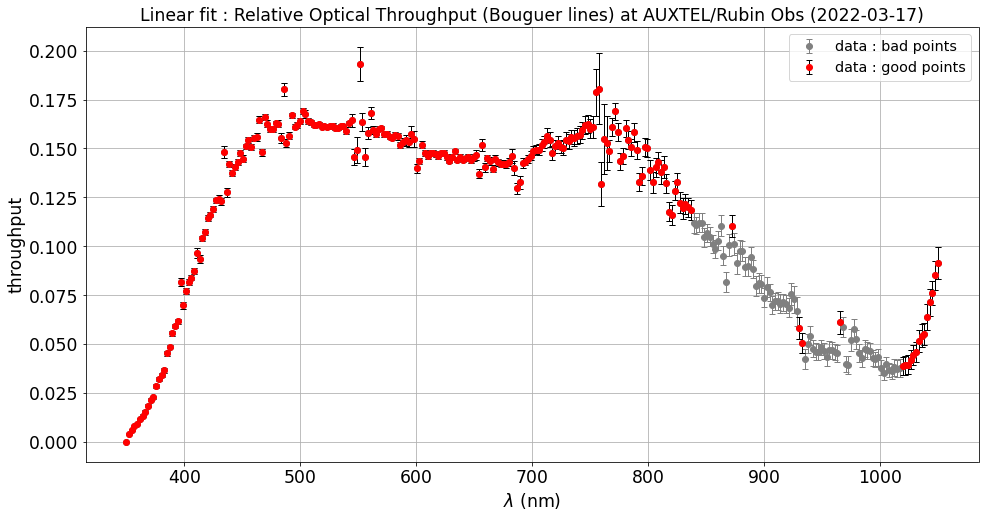

In [83]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
ax.errorbar(w_s1,transm_s1,yerr=etransm_s1,  fmt = 'o', color="grey",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1, label="data : bad points")
ax.errorbar(w_s1[flag],transm_s1[flag],yerr=etransm_s1[flag],  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1, label="data : good points")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Linear fit : Relative Optical Throughput (Bouguer lines) at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()

# TOA Spectrum

In [84]:
title=f"instrumental magnitude vs airmass at {SITE} ({DATE})"

Remove wavelength 516, bad fit slope = -0.15256925541359734, intercept = 28.277061323346608
Remove wavelength 553, bad fit slope = -0.1164911629497801, intercept = 28.56870679122188
Remove wavelength 589, bad fit slope = -0.08781408189797196, intercept = 29.074250076035216
Remove wavelength 626, bad fit slope = -0.01165367710755976, intercept = 29.17424777535941
Remove wavelength 663, bad fit slope = -0.043125078745839165, intercept = 29.79492213529002


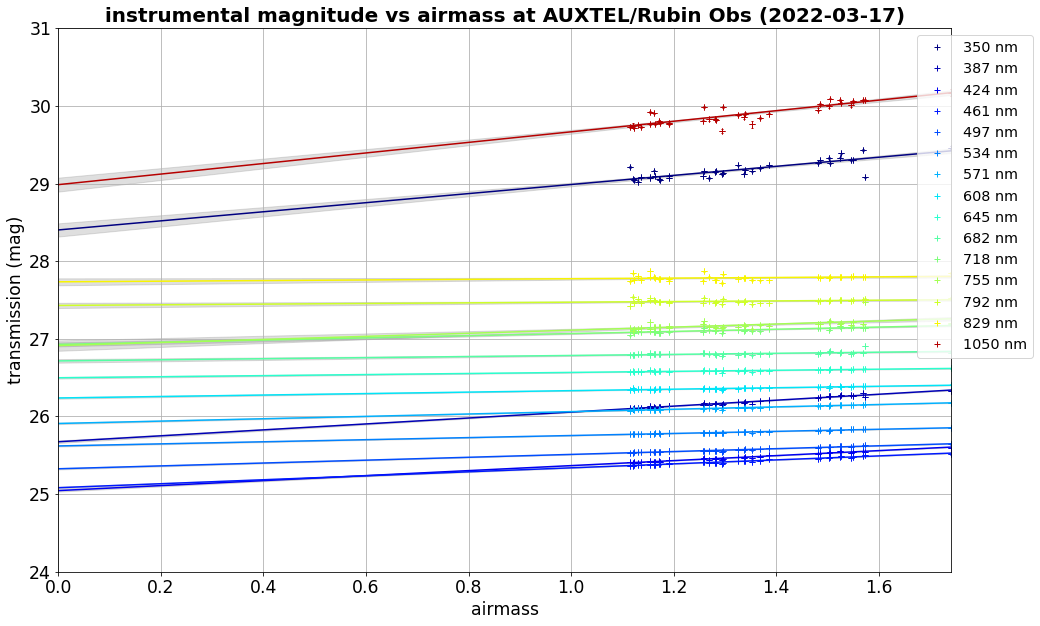

In [85]:
w,m,e,flag,res=GetBouguerLinesAtm(NPOINTSVIEW,WL,AirM,Mags2,EMags2,title=title,FLAG_PLOT=True,YMIN=24,YMAX=31,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [86]:
w_s2,m_s2,em_s2,flag,res=GetBouguerLinesAtm(NPOINTSSAVE,WL,AirM,Mags2,EMags2,FLAG_PLOT=False,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [87]:
transm_s2=np.power(10,-m_s2/2.5)
etransm_s2=em_s2*transm_s2

In [88]:
factor=1.0 # suppose Spectractor has divided the flux by Ronchi efficiency
transm_s2=transm_s2*factor
etransm_s2=etransm_s2*factor

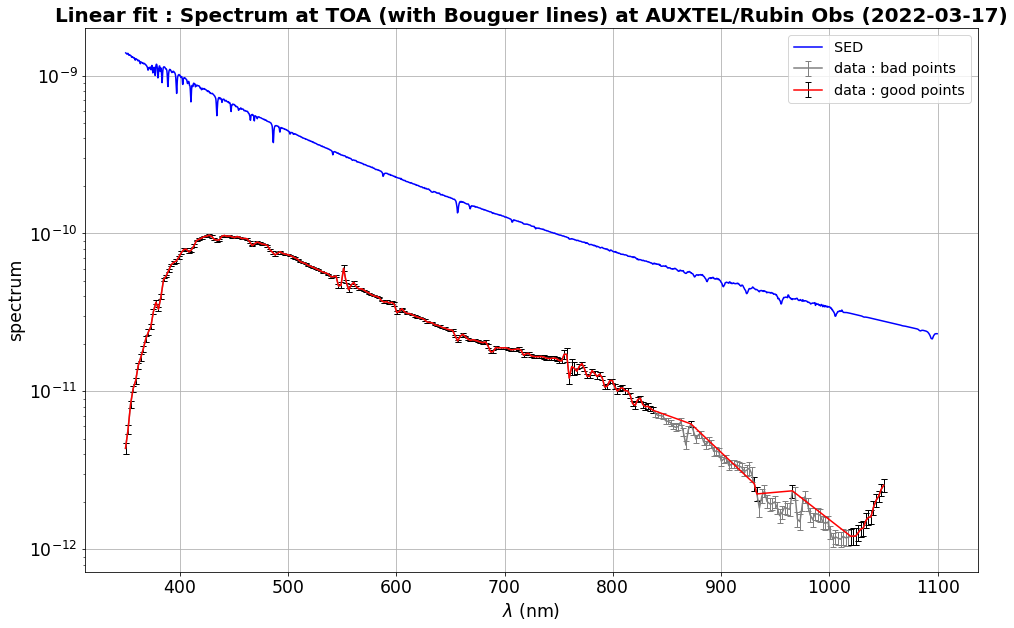

In [95]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.errorbar(w_s2,transm_s2,yerr=etransm_s2,  fmt = '-', color="grey",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="data : bad points")
ax.errorbar(w_s2[flag],transm_s2[flag],yerr=etransm_s2[flag],  fmt = '-', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data : good points")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
plt.plot(sed_w,sed_f,"b-",label="SED")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Linear fit : Spectrum at TOA (with Bouguer lines) at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.legend()
ax.grid()
ax.set_yscale('log')

# Save in file

In [90]:
dfout = pd.DataFrame()

In [91]:
dfout["wavelength"]=w_s1
dfout["throu"]=transm_s1
dfout["errthrou"]=etransm_s1
dfout["sedtoa"]=transm_s2
dfout["errsedtoa"]=etransm_s2

In [92]:
dfout

,wavelength,throu,errthrou,sedtoa,errsedtoa
0,350.000000,4.357072e-12,3.706748e-13,4.357072e-12,3.706748e-13
1,352.341137,4.152560e-03,2.873682e-04,5.735086e-12,3.968832e-13
2,354.682274,6.215233e-03,3.293554e-04,8.300252e-12,4.398440e-13
3,357.023411,7.981770e-03,3.762721e-04,1.039256e-11,4.899201e-13
4,359.364548,9.320846e-03,4.082418e-04,1.167808e-11,5.114859e-13
...,...,...,...,...,...
295,1040.635452,6.406987e-02,6.580580e-03,1.843475e-12,1.893423e-13
296,1042.976589,7.133512e-02,6.697432e-03,2.036771e-12,1.912261e-13
297,1045.317726,7.611959e-02,6.148429e-03,2.157993e-12,1.743082e-13
298,1047.658863,8.514499e-02,7.267698e-03,2.387560e-12,2.037944e-13


In [93]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 